# Graduated Cylindrical Shell (GCS) Model Applied to Multi-Spacecraft Observations

> **Author:** Alessandro Liberatore (alessandro.liberatore@inaf.it)  
> **Institute:** INAF - National Institute for Astrophysics  
> **Date:** Jan. 2026


This Jupyter Notebook demonstrates how to apply the Graduated Cylindrical Shell (GCS) model to data applied to multi-spacecraft observations.

The GCS model, introduced by Thernisien et al. ([2009](https://link.springer.com/article/10.1007/s11207-009-9346-5), [2011](https://iopscience.iop.org/article/10.1088/0067-0049/194/2/33)), is a forward-modeling technique designed to reconstruct the **3D geometry**, **orientation**, and **propagation direction** of CMEs. It represents the CME as a 3D croissant-shaped flux rope, defined by six key parameters (see Figure 1 in Thernisien et al. [2006](https://iopscience.iop.org/article/10.1086/508254)):

- **Height** ($h$): Distance of the CME apex from the Sun’s center  
- **Longitude** ($Lon$): CME propagation direction
- **Latitude** ($Lat$): CME propagation direction
- **Aspect ration** ($k$): Controls the conical shape (through the sine of half-angle of the legs cone, $\delta$)
- **Half-angle between the legs** ($\alpha$): Defines the CME angular width  
- **Tilt angle** ($tilt$): Orientation of the CME’s flux rope axis

When observations from multiple viewpoints (e.g., Solar Orbiter, STEREO, SOHO) are available, these parameters are optimized *so that the model projection matches the CME morphology in all images*.

The model can then be expanded **self-similarly** to track the CME’s evolution over time. From the apex height as a function of time, the CME’s **velocity** can be estimated.

Install necessary packages for this notebook. Note: The core of the GCS code used in this notebook is based on the implementation from [this GitHub repository](https://github.com/johan12345/gcs_python.git). We adapted it to work with our multi-spacecraft observations, but all the fundamental routines for defining the 3D CME structure come from that original code.

In [ ]:
!pip install sunpy -q
!pip install cmcrameri -q
!pip install pyqtwebengine -q
!pip install git+https://github.com/johan12345/gcs_python.git -q

  Preparing metadata (setup.py) ... done


Import necessary Python packages for this notebook:

In [ ]:
import os
import sys
import sunpy.map
import subprocess
import numpy as np
import datetime as dt
import astropy.units as u
from astropy.io import fits
from astropy.time import Time
from sunpy.sun import constants
import matplotlib.pyplot as plt
from gcs.geometry import gcs_mesh_sunpy
from astropy.visualization import ImageNormalize, PowerStretch

**Import Metis Map**

As the Metis Map is not part of Sunpy yet, you need to explicitely import a custom implementation.
For loading the custom `METISMap` , you can use the helper function below to clone the repository and add it to `sys.path`.

In [ ]:
# ------------------------------------------------
# Helper function to clone or update a GitHub repository and add it to sys.path
# ------------------------------------------------

def load_repo(repo_url, repo_name=None, base_path="."):
    """
    Clone (or update) a GitHub repository and add it to sys.path.

    Parameters
    ----------
    repo_url : str
        The HTTPS GitHub URL (public or private).
    repo_name : str, optional
        Name of the directory to clone into. If None, inferred from URL.
    base_path : str
        Directory where the repository will be placed.

    Returns
    -------
    str
        Full repository path.
    """

    # Infer repo name if needed
    if repo_name is None:
        repo_name = repo_url.rstrip("/").split("/")[-1].replace(".git", "")

    repo_path = os.path.join(base_path, repo_name)

    # Clone or update
    if not os.path.exists(repo_path):
        print(f"📥 Cloning repository: {repo_url}")
        subprocess.run(["git", "clone", repo_url, repo_path], check=True)
    else:
        print(f"🔄 Repository already exists. Pulling latest changes...")
        subprocess.run(["git", "-C", repo_path, "pull"], check=True)

    # Add to Python path
    if repo_path not in sys.path:
        sys.path.append(repo_path)

    print(f"✅ Repository ready at: {repo_path}")
    return repo_path

## Example usage (commented out by default):
repo_path = load_repo("https://github.com/gjerse/metisRepo.git", base_path="/content")
## repo_path = load_repo(REPO_URL, base_path=".")       # Local or Binder
## repo_path = load_repo(REPO_URL, base_path="/workspaces")  # Codespaces

sys.path.append("/content/test")

🔄 Repository already exists. Pulling latest changes...
✅ Repository ready at: /content/metisRepo


In [ ]:
from metis_map_vAB import METISMap
print("METISMap imported successfully.")

METISMap imported successfully.


In [ ]:
!pip install git+https://gitlab-as.oma.be/P3SC/aspiicsmap.git -q

from aspiicsmap import ASPIICSMap
print("ASPIICSMap imported successfully.")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ASPIICSMap imported successfully.


Mount the Drive containing the data (or alternatively, download the data online as shown in the notebooks dedicated to each spacecraft).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read what is inside the Drive (link to data: https://drive.google.com/drive/folders/1tr_7Cd5vZp3uht6b3TvTC-inuPVpcKaH?usp=sharing)

In [ ]:
# ------------------------------------------------
# Metis images
# ------------------------------------------------
Metis_path = "/content/drive/Shared drives/ISRO-ESA_2026/Data/Metis_20250916/"
#os.listdir(Metis_path)  # list of all elements in "Metis_path"
Metis_pb_files = [os.path.join(Metis_path, f) for f in os.listdir(Metis_path) if "pb" in f]
print(f"Number of Metis pB images: {len(Metis_pb_files)}")


# ------------------------------------------------
# ASPIICS images
# ------------------------------------------------
ASPIICS_path = "/content/drive/Shared drives/ISRO-ESA_2026/Data/ASPIICS_20250916/"
ASPIICS_pb_files = [os.path.join(ASPIICS_path, f) for f in os.listdir(ASPIICS_path) if "bt" in f]
print(f"Number of ASPIICS images: {len(ASPIICS_pb_files)}")

Number of Metis pB images: 47
Number of ASPIICS images: 85


Now, the images need to be reordered in time. When selecting images from multiple spacecraft, it’s important to choose the ones that are as close as possible in observation time to ensure proper comparison.

For this reason, we use the keyword date_sun instead of date_obs. The date_sun keyword accounts not only for the observation time but also for the light travel time from the Sun to the spacecraft, ensuring that the images are properly synchronized for analysis.

In [ ]:
from astropy.io import fits
from astropy.time import Time
import sunpy.map

# ------------------------------------------------
# Read all relevant metadata ONCE
# ------------------------------------------------
def read_fits_metadata(fits_file,
                       date_obs_key='DATE-OBS',
                       date_sun_key='date_sun',
                       extension=0):
    with fits.open(fits_file, memmap=True) as hdul:
        hdr = hdul[extension].header
        return {
            "file": fits_file,
            "date_obs": Time(hdr[date_obs_key]),
            "date_sun": Time(hdr[date_sun_key])
        }

# ------------------------------------------------
# Read metadata for all files
# ------------------------------------------------
Metis_meta = [read_fits_metadata(f) for f in Metis_pb_files]
ASPIICS_meta = [read_fits_metadata(f) for f in ASPIICS_pb_files]

# ------------------------------------------------
# Sort by DATE-OBS (already in memory)
# ------------------------------------------------
Metis_meta_sorted = sorted(Metis_meta, key=lambda x: x["date_obs"])
ASPIICS_meta_sorted = sorted(ASPIICS_meta, key=lambda x: x["date_obs"])

# ------------------------------------------------
# Extract ordered lists if needed
# ------------------------------------------------
Metis_pb_files_sorted   = [m["file"] for m in Metis_meta_sorted]
ASPIICS_pb_files_sorted = [m["file"] for m in ASPIICS_meta_sorted]

Metis_date_obs = [m["date_obs"] for m in Metis_meta_sorted]
Metis_dates    = [m["date_sun"] for m in Metis_meta_sorted]

ASPIICS_date_obs = [m["date_obs"] for m in ASPIICS_meta_sorted]
ASPIICS_dates    = [m["date_sun"] for m in ASPIICS_meta_sorted]

# ------------------------------------------------
# Print table
# ------------------------------------------------

def safe_iso(arr, i):
    return arr[i].iso if i < len(arr) else ""

n = max(len(Metis_dates), len(ASPIICS_dates))

print("Idx | Metis (date_sun)        | Metis (date_obs)        | ASPIICS (date_sun)      | ASPIICS (date_obs)")
print("-" * 110)

for i in range(n):
    print(
        f"{i:3d} | "
        f"{safe_iso(Metis_dates, i):24s} | "
        f"{safe_iso(Metis_date_obs, i):24s} | "
        f"{safe_iso(ASPIICS_dates, i):24s} | "
        f"{safe_iso(ASPIICS_date_obs, i):24s}"
    )

Idx | Metis (date_sun)        | Metis (date_obs)        | ASPIICS (date_sun)      | ASPIICS (date_obs)
--------------------------------------------------------------------------------------------------------------
  0 | 2025-09-16 02:45:34.510  | 2025-09-16 02:48:01.324  | 2025-09-16 03:52:08.731  | 2025-09-16 04:00:30.280 
  1 | 2025-09-16 02:57:34.520  | 2025-09-16 03:00:01.335  | 2025-09-16 03:53:08.732  | 2025-09-16 04:01:30.281 
  2 | 2025-09-16 03:09:34.530  | 2025-09-16 03:12:01.346  | 2025-09-16 03:54:08.733  | 2025-09-16 04:02:30.282 
  3 | 2025-09-16 03:21:34.540  | 2025-09-16 03:24:01.358  | 2025-09-16 03:55:08.734  | 2025-09-16 04:03:30.283 
  4 | 2025-09-16 03:33:34.550  | 2025-09-16 03:36:01.369  | 2025-09-16 03:57:08.736  | 2025-09-16 04:05:30.284 
  5 | 2025-09-16 03:45:34.570  | 2025-09-16 03:48:01.381  | 2025-09-16 03:58:08.737  | 2025-09-16 04:06:30.285 
  6 | 2025-09-16 03:57:34.590  | 2025-09-16 04:00:01.405  | 2025-09-16 03:59:08.737  | 2025-09-16 04:07:30.286 
  

Metis map index: 9. Closest ASPIICS map index: 33. Time difference: 25.86 s
solar orbitermetisvl-pb


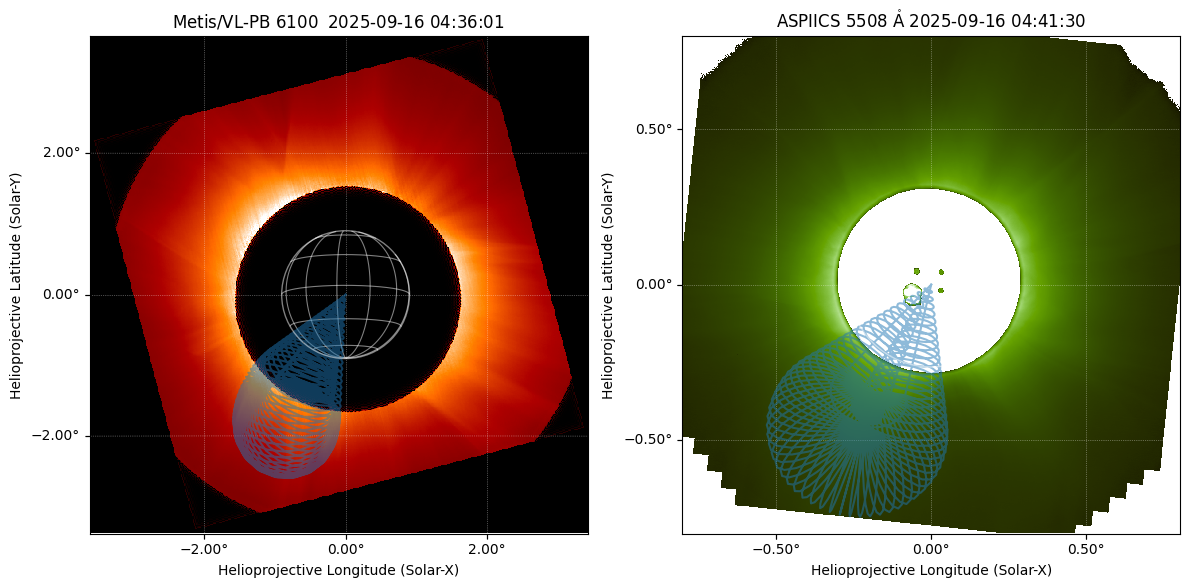

In [ ]:
import warnings
from sunpy.util.exceptions import SunpyUserWarning
from astropy.utils.exceptions import AstropyDeprecationWarning

warnings.filterwarnings("ignore", category=SunpyUserWarning)
warnings.filterwarnings(
    "ignore",
    category=AstropyDeprecationWarning
)

# ------------------------------------------------
# Function to load a single SunPy map from a FITS file
# ------------------------------------------------
def load_map(fits_file, extension=0):
    with fits.open(fits_file) as hdul:
        data = hdul[extension].data      # extract the image data
        header = hdul[extension].header  # extract the FITS header
    return sunpy.map.Map(data, header)   # create and return a SunPy Map


# ------------------------------------------------
# Find the ASPIICS map closest in time to a specific Metis map
# ------------------------------------------------
metis_idx = 9  # Metis map under consideration
metis_time = Metis_dates[metis_idx]


# Compute time differences in seconds
time_diffs = [(abs(aspiics_time - metis_time).sec, i) for i, aspiics_time in enumerate(ASPIICS_dates)]
min_diff, aspiics_idx = min(time_diffs)

print(f"Metis map index: {metis_idx}. Closest ASPIICS map index: {aspiics_idx}. Time difference: {min_diff:.2f} s")

# ------------------------------------------------
# Load maps
# ------------------------------------------------
Metis_map = load_map(Metis_pb_files_sorted[metis_idx])
ASPIICS_map = load_map(ASPIICS_pb_files_sorted[aspiics_idx])


# ------------------------------------------------
# Plot side by side
# ------------------------------------------------
fig = plt.figure(figsize=(12,6))

# Metis

# Rotate the Metis map
Metis_map_rotated = Metis_map.rotate()
ax1 = fig.add_subplot(1, 2, 1, projection=Metis_map_rotated)

Metis_map_rotated.contr_cut = None
Metis_map_rotated.plot_settings["norm"] = ImageNormalize(
    vmin=0,
    vmax=np.nanpercentile(Metis_map_rotated.data, 99.9),
    stretch=PowerStretch(0.2)
)

# Safety: avoid conflicts if vmin/vmax were previously stored in plot_settings
Metis_map_rotated.plot_settings.pop("vmin", None)
Metis_map_rotated.plot_settings.pop("vmax", None)

# Optional: add contextual overlays (solar limb + heliographic grid)
Metis_map_rotated.draw_limb(color="white", alpha=0.5)
Metis_map_rotated.draw_grid(color="white", alpha=0.5, grid_spacing=30*u.deg)
Metis_map_rotated.plot(axes=ax1)


# ASPIICS
ax2 = fig.add_subplot(1, 2, 2, projection=ASPIICS_map)
vmax_aspiics = np.nanpercentile(ASPIICS_map.data, 99)
ASPIICS_map.plot_settings["norm"] = ImageNormalize(
    vmin=0,
    vmax=np.nanpercentile(ASPIICS_map.data, 99.9),
    stretch=PowerStretch(0.2)
)
ASPIICS_map.plot(axes=ax2)
ASPIICS_map.draw_limb(axes=ax2, color='white', alpha=0.5)
ASPIICS_map.draw_grid(axes=ax2, color='white', alpha=0.5, grid_spacing=30*u.deg)

# ------------------------------------------------
# Helper function to set coordinate format
# ------------------------------------------------
def set_coord_format(ax, fmt='d.dd'):
    lon, lat = ax.coords
    lon.set_major_formatter(fmt)
    lat.set_major_formatter(fmt)

# Apply to both axes
set_coord_format(ax1)
set_coord_format(ax2)

# ------------------------------------------------
# Generate GCS mesh
# ------------------------------------------------
#-------------------------------------------------
#Time stamp n.1 - Metis n.ref: 7
#---------------
#half_angle = np.radians(12.16)
#height = 2.64
#kappa = 0.31
#lat = np.radians(-58.45)
#lon = np.radians(231.70)
#tilt = np.radians(54.12)
#-------------------------------------------------
#Time stamp n.2 - Metis n.ref: 8
#--------------
#half_angle = np.radians(12.16)
#height = 2.94
#kappa = 0.31
#lat = np.radians(-58.5)
#lon = np.radians(231.70)
#tilt = np.radians(54.12)
#-------------------------------------------------
#Time stamp n.3 - Metis n.ref: 9
#--------------
half_angle = np.radians(12.16)
height = 3.29
kappa = 0.31
lat = np.radians(-58.5)
lon = np.radians(231.70)
tilt = np.radians(54.12)
#------------------------------------------------
#Time stamp n.4 - Metis n.ref: 10
#--------------
#half_angle = np.radians(12.16)
#height = 3.56
#kappa = 0.31
#lat = np.radians(-58.5)
#lon = np.radians(231.70)
#tilt = np.radians(54.12)
#-------------------------------------------------


mesh = gcs_mesh_sunpy(Metis_dates[metis_idx], half_angle, height, 20, 20, 20, kappa, lat, lon, tilt)


# Plot GCS (to plot the full GCS mesh, uncomment the last two lines)
ax1.plot_coord(mesh, '-', ms=3, alpha = 0.5)
ax2.plot_coord(mesh, '-', ms=3, alpha = 0.5)

plt.tight_layout()
plt.show()

Image of interest | Metis map index: 9. Closest ASPIICS map index: 33. Time difference: 25.86 s
Previous image    | Metis map index: 8. Closest ASPIICS map index: 24. Time difference: 34.14 s


/tmp/ipython-input-45131275.py:40: RuntimeWarning: invalid value encountered in subtract
  ASPIICS_RD_data = ASPIICS_map.data - RDASPIICS_map.data


solar orbitermetisvl-pb


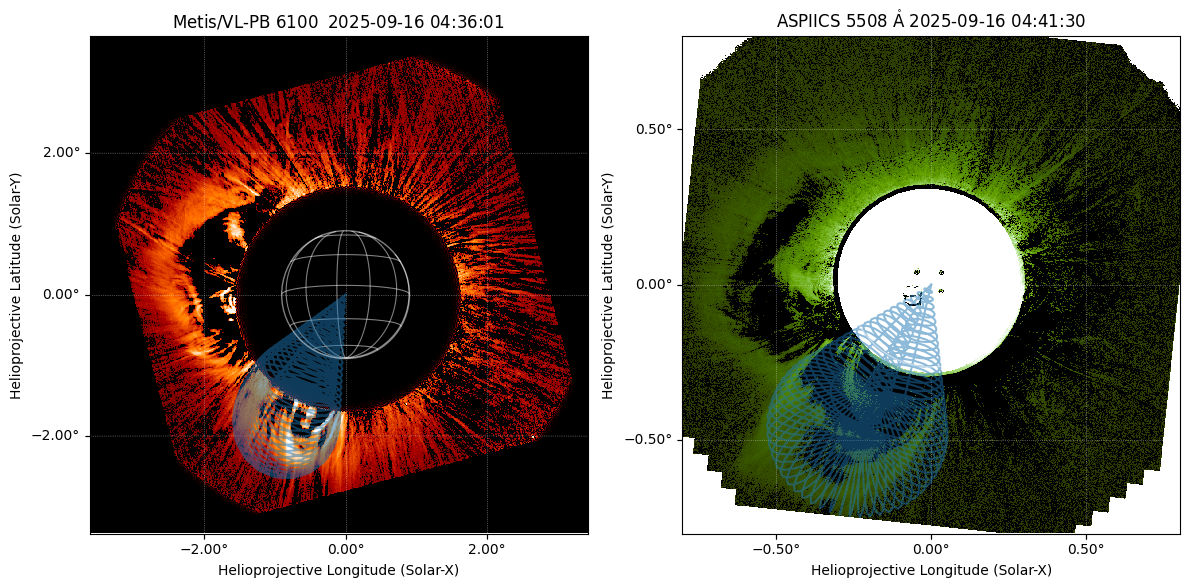

In [ ]:
# ------------------------------------------------
# Find the ASPIICS map closest in time to a specific Metis map
# ------------------------------------------------
metis_idx = 9  # Metis map under consideration
metis_time = Metis_dates[metis_idx]

# Compute time differences in seconds
time_diffs = [(abs(aspiics_time - metis_time).sec, i) for i, aspiics_time in enumerate(ASPIICS_dates)]
min_diff, aspiics_idx = min(time_diffs)

print(f"Image of interest | Metis map index: {metis_idx}. Closest ASPIICS map index: {aspiics_idx}. Time difference: {min_diff:.2f} s")


# ------------------------------------------------
# Find the image for the Running Difference
# ------------------------------------------------
RDmetis_idx = metis_idx-1  # Metis map under consideration
RDmetis_time = Metis_dates[RDmetis_idx]

# Compute time differences in seconds
RDtime_diffs = [(abs(aspiics_time - RDmetis_time).sec, i) for i, aspiics_time in enumerate(ASPIICS_dates)]
RDmin_diff, RDaspiics_idx = min(RDtime_diffs)

print(f"Previous image    | Metis map index: {RDmetis_idx}. Closest ASPIICS map index: {RDaspiics_idx}. Time difference: {RDmin_diff:.2f} s")


# ------------------------------------------------
# Load maps
# ------------------------------------------------
# Reference images
Metis_map = load_map(Metis_pb_files_sorted[metis_idx])
ASPIICS_map = load_map(ASPIICS_pb_files_sorted[aspiics_idx])

# Previous images
RDMetis_map = load_map(Metis_pb_files_sorted[RDmetis_idx])
RDASPIICS_map = load_map(ASPIICS_pb_files_sorted[RDaspiics_idx])

# Compute running difference data
Metis_RD_data = Metis_map.data - RDMetis_map.data
ASPIICS_RD_data = ASPIICS_map.data - RDASPIICS_map.data

# Create a NEW SunPy Map using the reference WCS/header
Metis_map = sunpy.map.Map(Metis_RD_data, Metis_map.meta)
ASPIICS_map = sunpy.map.Map(ASPIICS_RD_data, ASPIICS_map.meta)


# ------------------------------------------------
# Plot side by side
# ------------------------------------------------
fig = plt.figure(figsize=(12,6))

# Metis

# Rotate the Metis map
Metis_map_rotated = Metis_map.rotate()
ax1 = fig.add_subplot(1, 2, 1, projection=Metis_map_rotated)

Metis_map_rotated.contr_cut = None
Metis_map_rotated.plot_settings["norm"] = ImageNormalize(
    vmin=0,
    vmax=np.nanpercentile(Metis_map_rotated.data, 99.9),
    stretch=PowerStretch(0.2)
)

# Safety: avoid conflicts if vmin/vmax were previously stored in plot_settings
Metis_map_rotated.plot_settings.pop("vmin", None)
Metis_map_rotated.plot_settings.pop("vmax", None)

# Optional: add contextual overlays (solar limb + heliographic grid)
Metis_map_rotated.draw_limb(color="white", alpha=0.5)
Metis_map_rotated.draw_grid(color="white", alpha=0.5, grid_spacing=30*u.deg)
Metis_map_rotated.plot(axes=ax1)


# ASPIICS
ax2 = fig.add_subplot(1, 2, 2, projection=ASPIICS_map)
vmax_aspiics = np.nanpercentile(ASPIICS_map.data, 99)
ASPIICS_map.plot_settings["norm"] = ImageNormalize(
    vmin=0,
    vmax=np.nanpercentile(ASPIICS_map.data, 99.9),
    stretch=PowerStretch(0.2)
)
ASPIICS_map.plot(axes=ax2)
ASPIICS_map.draw_limb(axes=ax2, color='white', alpha=0.5)
ASPIICS_map.draw_grid(axes=ax2, color='white', alpha=0.5, grid_spacing=30*u.deg)

# ------------------------------------------------
# Helper function to set coordinate format
# ------------------------------------------------
def set_coord_format(ax, fmt='d.dd'):
    lon, lat = ax.coords
    lon.set_major_formatter(fmt)
    lat.set_major_formatter(fmt)

# Apply to both axes
set_coord_format(ax1)
set_coord_format(ax2)

# ------------------------------------------------
# Generate GCS mesh
# ------------------------------------------------
#-------------------------------------------------
#Time stamp n.1 - Metis n.ref: 7
#---------------
#half_angle = np.radians(12.16)
#height = 2.64
#kappa = 0.31
#lat = np.radians(-58.45)
#lon = np.radians(231.70)
#tilt = np.radians(54.12)
#-------------------------------------------------
#Time stamp n.2 - Metis n.ref: 8
#--------------
#half_angle = np.radians(12.16)
#height = 2.94
#kappa = 0.31
#lat = np.radians(-58.5)
#lon = np.radians(231.70)
#tilt = np.radians(54.12)
#-------------------------------------------------
#Time stamp n.3 - Metis n.ref: 9
#--------------
half_angle = np.radians(12.16)
height = 3.29
kappa = 0.31
lat = np.radians(-58.5)
lon = np.radians(231.70)
tilt = np.radians(54.12)
#------------------------------------------------
#Time stamp n.4 - Metis n.ref: 10
#--------------
#half_angle = np.radians(12.16)
#height = 3.56
#kappa = 0.31
#lat = np.radians(-58.5)
#lon = np.radians(231.70)
#tilt = np.radians(54.12)
#-------------------------------------------------

mesh = gcs_mesh_sunpy(Metis_dates[metis_idx], half_angle, height, 20, 20, 20, kappa, lat, lon, tilt)

# Plot GCS (to plot the full GCS mesh, uncomment the last two lines)
ax1.plot_coord(mesh, '-', ms=3, alpha = 0.5)
ax2.plot_coord(mesh, '-', ms=3, alpha = 0.5)

plt.tight_layout()
plt.show()

### Interpretation

The GCS wireframe projected onto the Metis and ASPIICS images represents
the 3D structure of the CME flux rope at the time of observation from the two points of view.
By adjusting the model parameters (height, longitude, latitude, tilt, etc.),
it is possible to reproduce the observed CME morphology.

## Height–Time (HT) Analysis

The *Height–Time* (HT) diagram is one of the most fundamental diagnostics
for analyzing the kinematics of Coronal Mass Ejections (CMEs).

Once the **Graduated Cylindrical Shell (GCS)** model has been fitted to
a CME at different times, the height of the CME apex (*H*, expressed in solar radii, Rsun)
can be plotted as a function of time (*t*).  
The slope of this curve gives the CME's **radial velocity**:

$v = \frac{dH}{dt}$

and the curvature, if any, provides information on its **acceleration**.

---

**Typical procedure:**

1. For each image time (from Metis, ASPIICS, COR2, LASCO, etc.),  
   fit the GCS model and record the apex height and observation time.
2. Convert observation times to seconds or hours.
3. Plot *height vs. time* and fit a linear (or quadratic) function:
   - Linear fit → constant velocity
   - Quadratic fit → velocity + acceleration term


/tmp/ipython-input-496251065.py:49: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(times, heights_rsun, 'o', color='royalblue', label='GCS measurements')
/tmp/ipython-input-496251065.py:50: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(t_fit, h_fit, '-', color='darkorange', label=f'Linear fit: v = {v_kms:.0f} km/s')


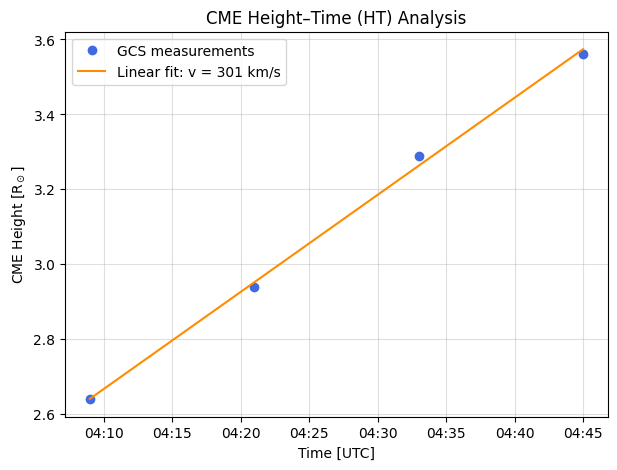

In [ ]:
# ------------------------------------------------------------
# Height–Time (HT) analysis of the CME apex
# ------------------------------------------------------------
# Example: height values obtained from GCS fits at different times
# (values are illustrative – replace with real ones from your fits)
# ------------------------------------------------------------

from datetime import datetime
from matplotlib.dates import date2num, DateFormatter
from scipy.optimize import curve_fit

# ------------------------------------------------------------
# Example input data
# ------------------------------------------------------------
times_str = [
    "2025-09-16T04:09:00",
    "2025-09-16T04:21:00",
    "2025-09-16T04:33:00",
    "2025-09-16T04:45:00"
]
heights_rsun = [2.64, 2.94, 3.29, 3.56]  # CME apex heights [Rsun]

# Convert to datetime objects and numeric (matplotlib date units)
times = [datetime.fromisoformat(t) for t in times_str]
times_num = date2num(times)

# ------------------------------------------------------------
# Define a linear fit function: height = v * t + H0
# ------------------------------------------------------------
def linear_fit(t, v, H0):
    return v * (t - times_num[0]) * 24 + H0  # 24 converts days → hours

# Fit the data
params, _ = curve_fit(linear_fit, times_num, heights_rsun)
v_fit, H0_fit = params

# Compute fitted curve
t_fit = np.linspace(min(times_num), max(times_num), 100)
h_fit = linear_fit(t_fit, v_fit, H0_fit)

# Convert velocity to km/s
Rsun_km = constants.get('radius').to(u.km).value
v_kms = v_fit * Rsun_km / 3600  # Rsun/hour → km/s

# ------------------------------------------------------------
# Plot Height–Time diagram
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot_date(times, heights_rsun, 'o', color='royalblue', label='GCS measurements')
ax.plot_date(t_fit, h_fit, '-', color='darkorange', label=f'Linear fit: v = {v_kms:.0f} km/s')

ax.set_xlabel("Time [UTC]")
ax.set_ylabel("CME Height [R$_\\odot$]")
ax.set_title("CME Height–Time (HT) Analysis")
ax.legend()
ax.grid(True, alpha=0.4)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.show()


The result is used to estimate CME propagation speed
and to initialize heliospheric models such as DBM (Drag-Based Model, [link](https://swe.ssa.esa.int/graz-dbem-federated)) or WSA-Enlil ([link](https://ccmc.gsfc.nasa.gov/ror/requests/SH/E28/enlil_user_registration.php)).

---